<a href="https://colab.research.google.com/github/Nightskull100/Dress-Type-Detection-using-CNN/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# Download training and testing data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 13578113.29it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 276980.13it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5109192.26it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10156292.09it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



In [2]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [3]:
# prepare dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 28, 28]) torch.Size([64])
Ankle Boot


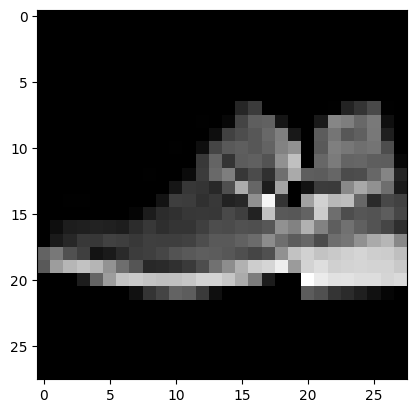

In [5]:
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

In [6]:
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device

In [7]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [8]:
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size x 784
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_epoch_loss = train_epoch_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    # flatten images to batch_size x 784
                    images = images.view(images.shape[0], -1)
                    # make predictions
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss

                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)

                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    # save epoch losses for plotting
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    # print stats for this epoch
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    # Finally plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.5688990403413772823, val_loss: 0.4267962574958801270,  val_acc: 84.33%
Epoch: 1 -> train_loss: 0.4584171397884686527, val_loss: 0.4239452183246612549,  val_acc: 84.19%
Epoch: 2 -> train_loss: 0.4243147429029147100, val_loss: 0.3911571502685546875,  val_acc: 85.70%
Epoch: 3 -> train_loss: 0.4035343632698059069, val_loss: 0.3909696638584136963,  val_acc: 85.31%
Epoch: 4 -> train_loss: 0.3900834276477495588, val_loss: 0.3862922787666320801,  val_acc: 86.09%
Epoch: 5 -> train_loss: 0.3783403584559758559, val_loss: 0.3543260097503662109,  val_acc: 86.84%
Epoch: 6 -> train_loss: 0.3689573630094528101, val_loss: 0.3688744604587554932,  val_acc: 86.43%
Epoch: 7 -> train_loss: 0.3585608521302541263, val_loss: 0.3623376786708831787,  val_acc: 86.64%
Epoch: 8 -> train_loss: 0.3580319956441720408, val_loss: 0.3374220132827758789,  val_acc: 87.37%
Epoch: 9 -> train_loss: 0.3441609425942103173, val_loss: 0.3434705436229705811,  val_acc: 87.12%
Epoch: 10 -> train_loss: 0.341

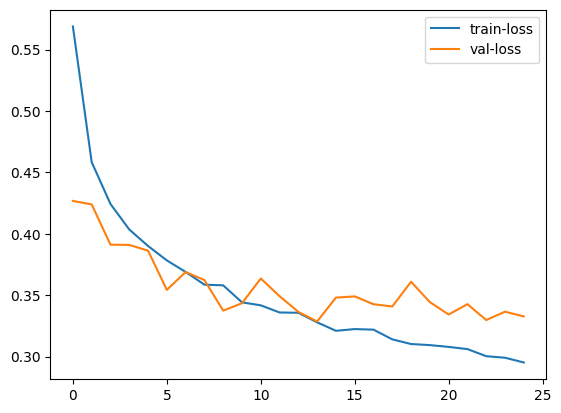

In [9]:
# Train and validate
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

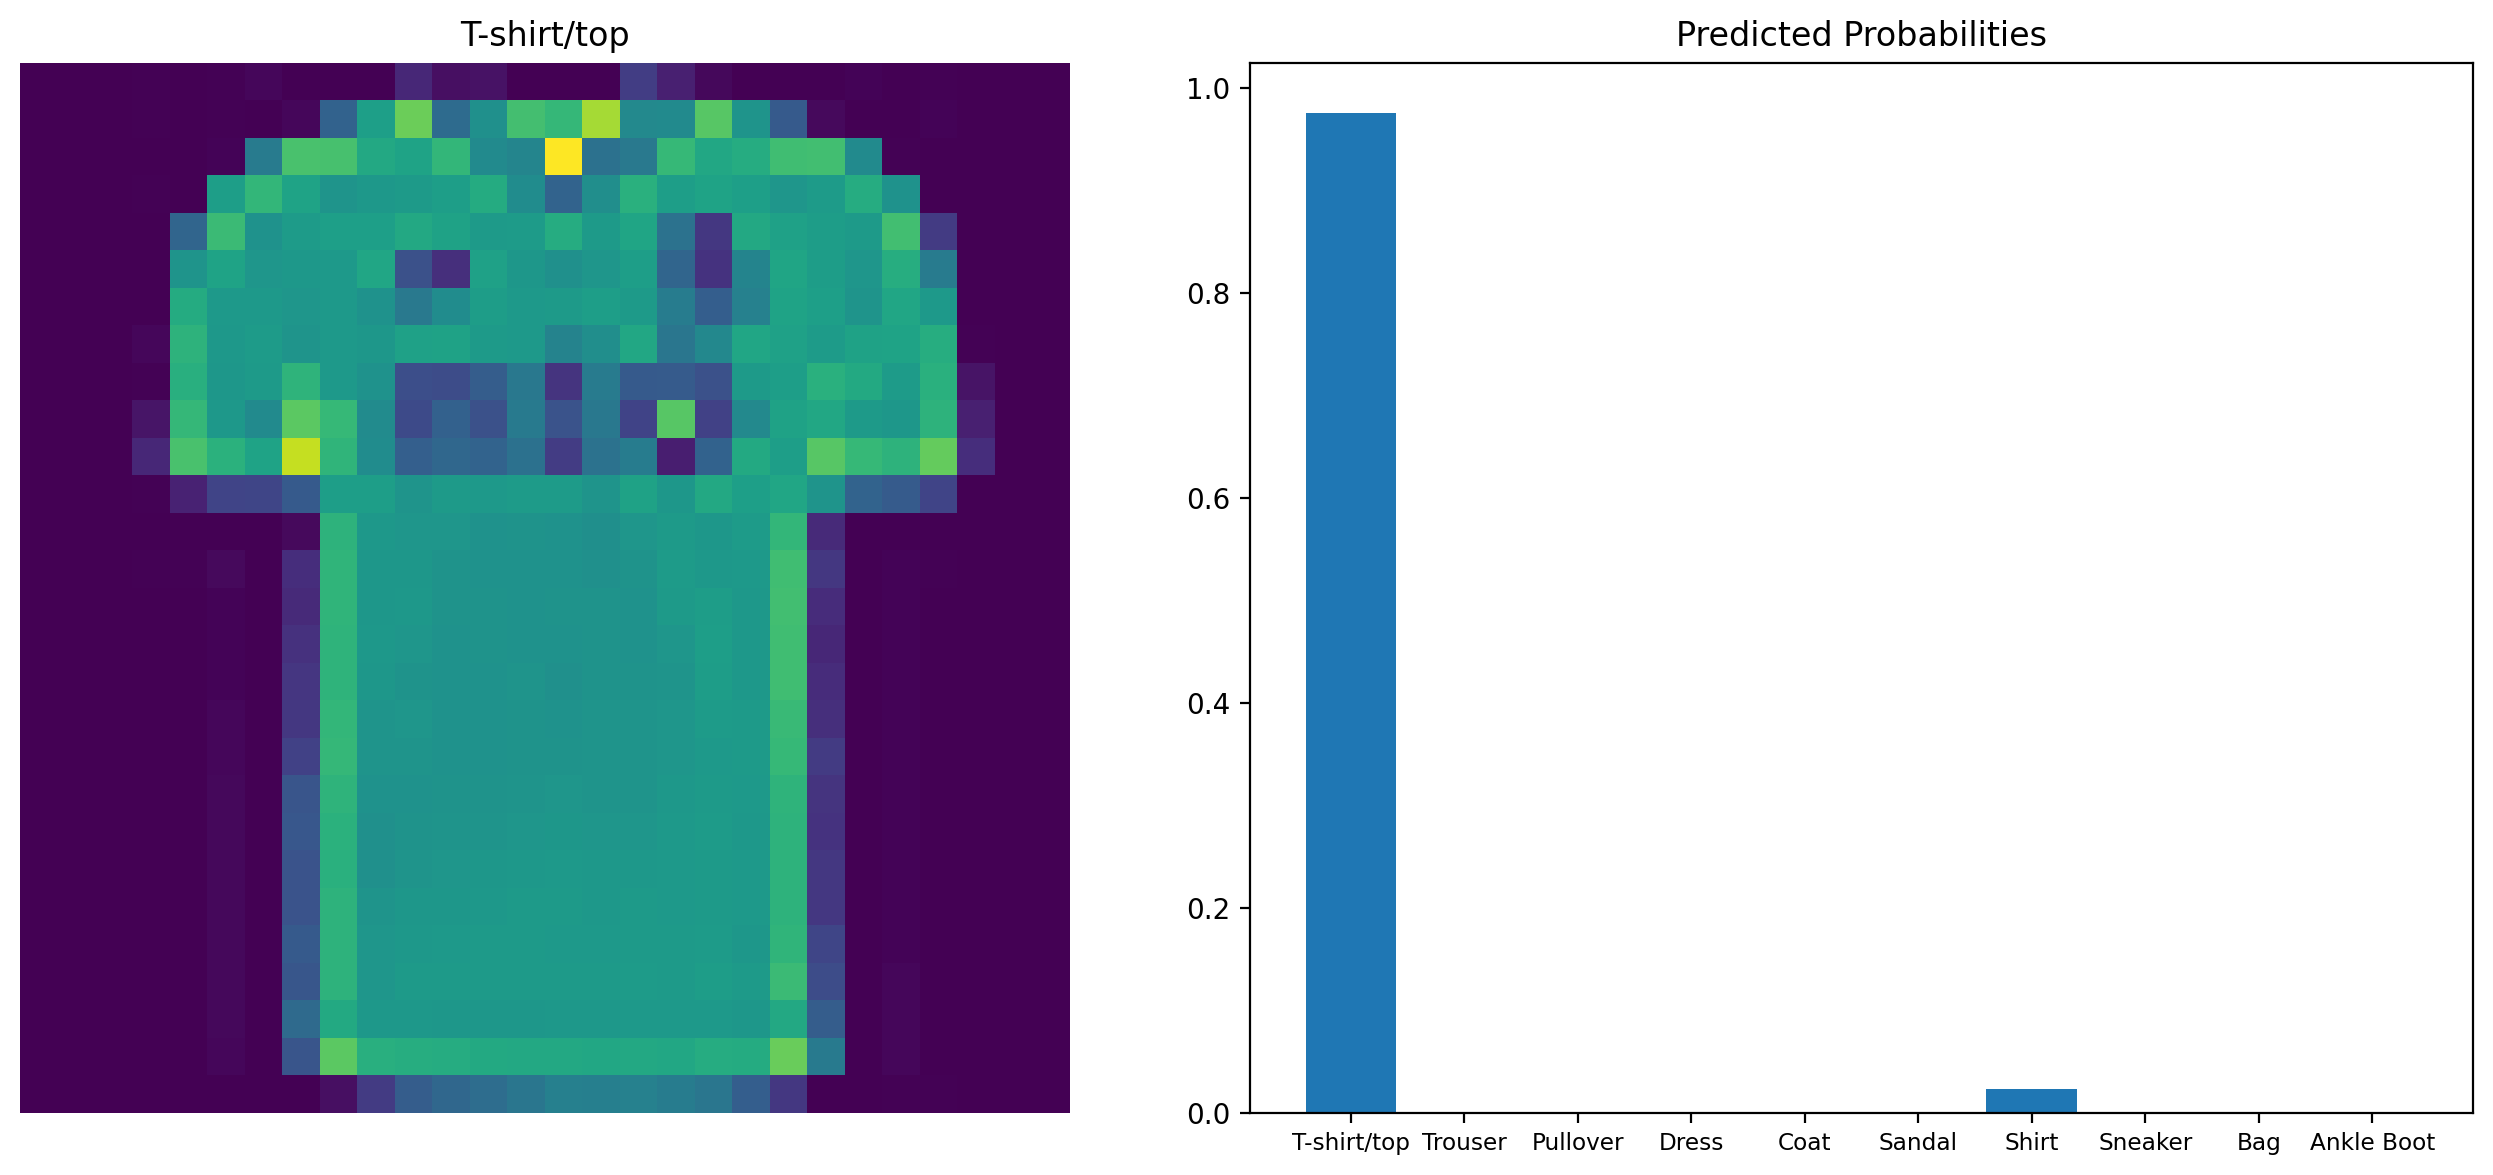

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out the network!
dataiter = iter(test_dl)
images, labels = dataiter.__next__()
images, labels = images.to(device), labels.to(device)
index = 49
img, label = images[index], labels[index]
# Convert 2D image to 1D vector
img = img.view(img.shape[0], -1)

# Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img))

# Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(images[index].cpu().numpy().squeeze())
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

Enter the image URL: https://img.freepik.com/free-photo/white-tshirt-template-wooden-background_1409-4097.jpg?t=st=1723303527~exp=1723307127~hmac=f4bef4209d1cc5adb20612d6689ecbd122fd37393d1bcd2b6272ae50ff7d4334&w=740


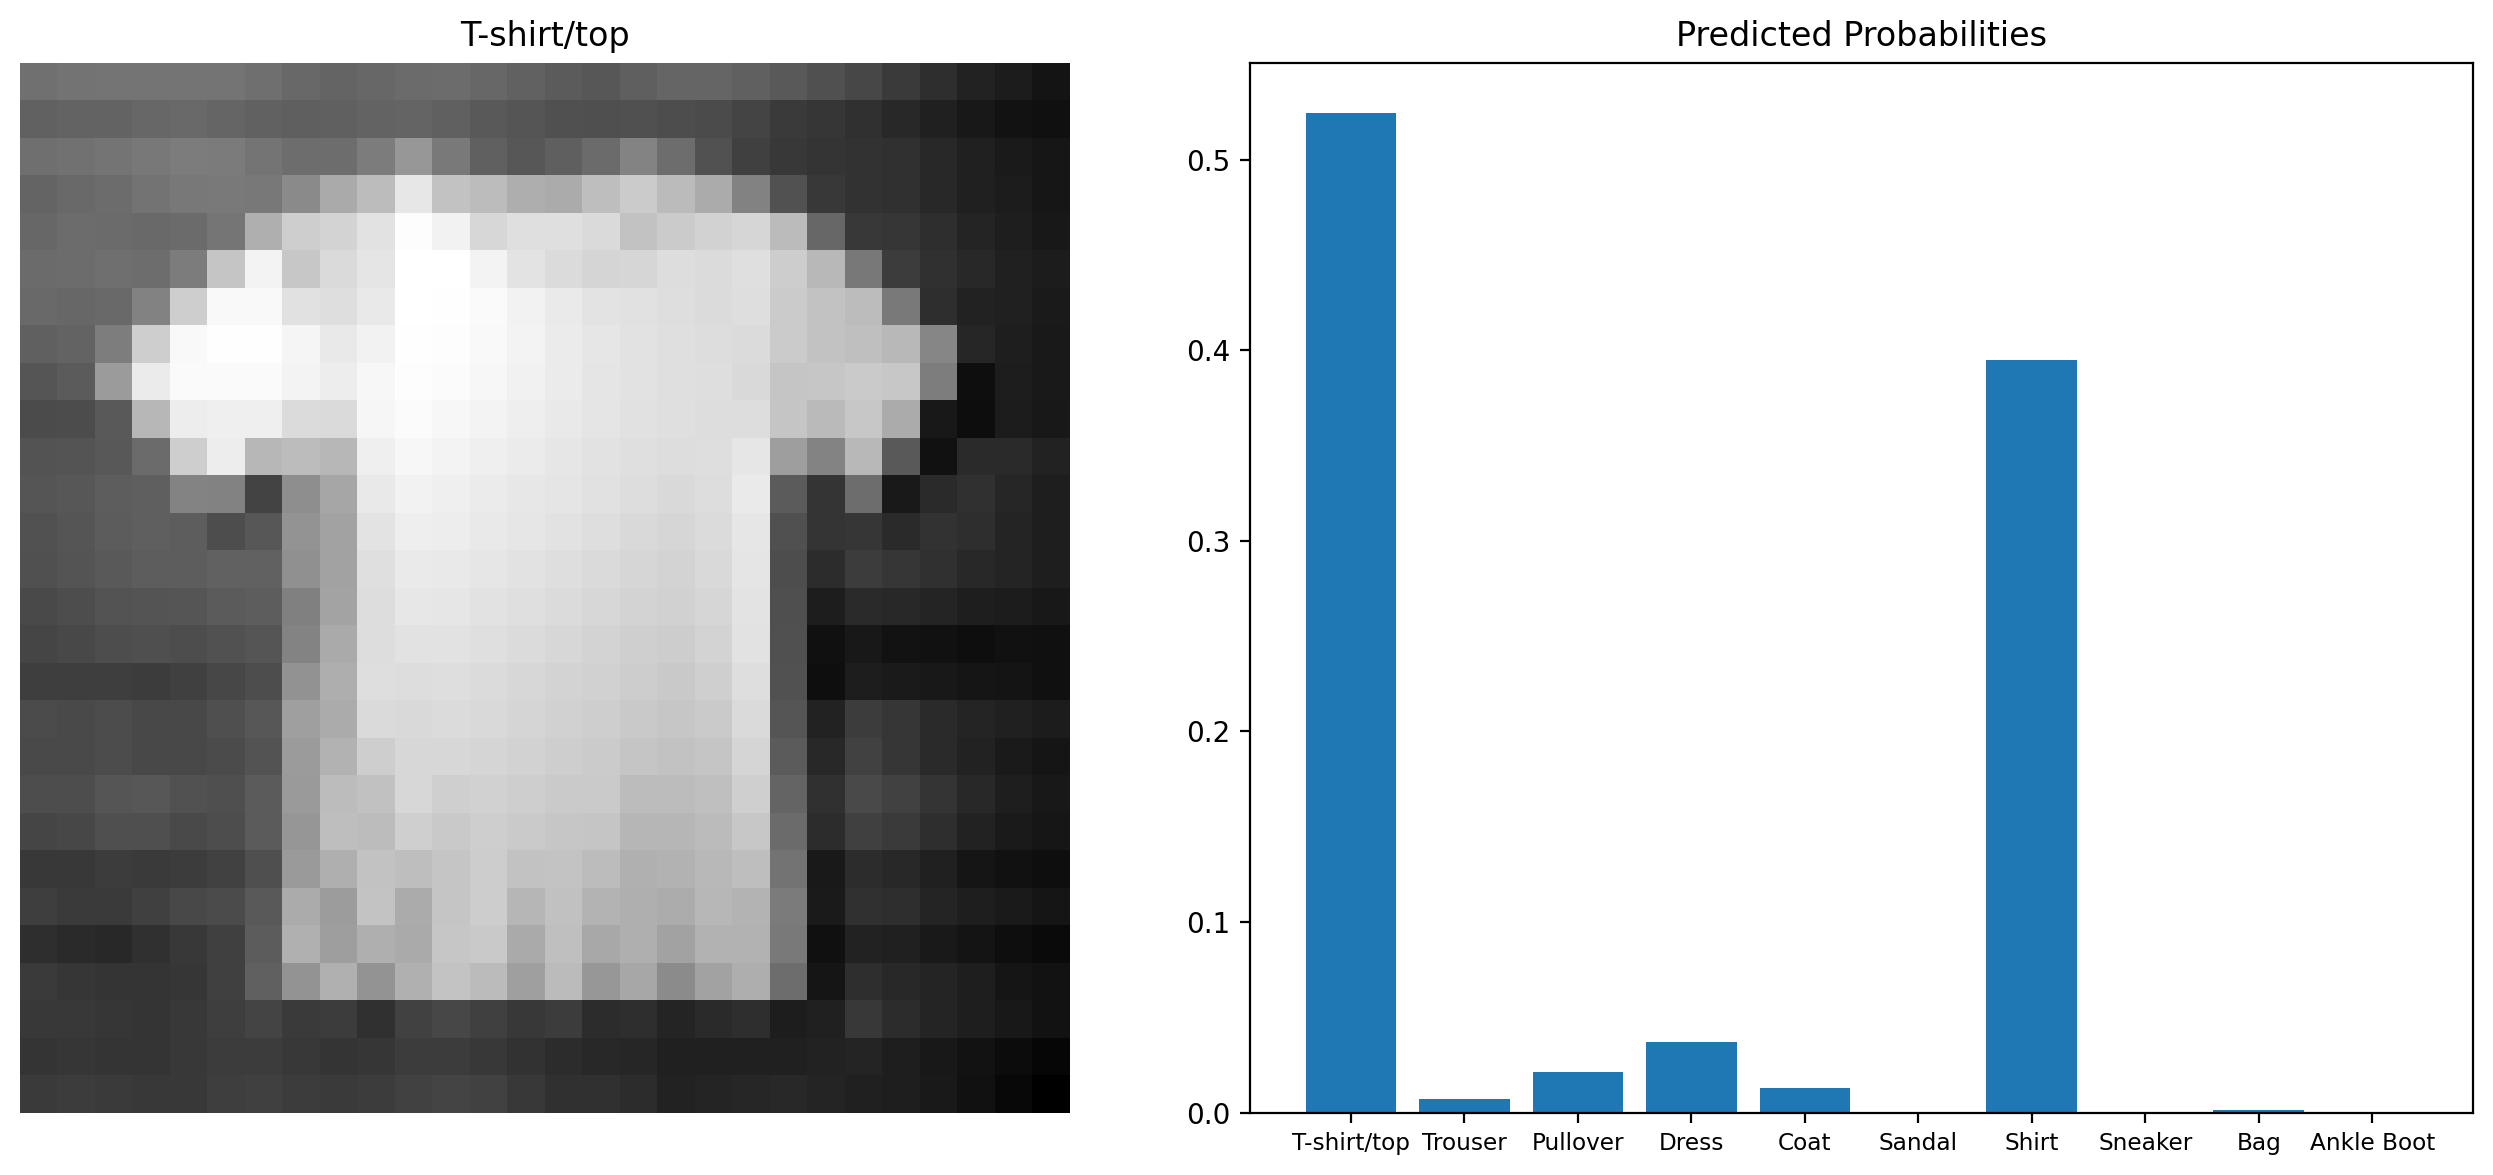

In [25]:
import requests
from PIL import Image
import io
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to preprocess the image from URL
def preprocess_image_from_url(image_url):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),                 # Resize to 28x28 pixels
        transforms.ToTensor(),                      # Convert image to tensor
        transforms.Normalize((0.5,), (0.5,))        # Normalize the tensor
    ])

    # Fetch the image from the URL
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Check for HTTP errors
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    except requests.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except IOError as e:
        print(f"Error opening image: {e}")
        return None

    # Apply the transform to the image
    image_tensor = transform(image)

    # Add a batch dimension (needed for model input)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

    return image_tensor

# Get the image URL from the user
image_url = input("Enter the image URL: ")

# Preprocess the image
image_tensor = preprocess_image_from_url(image_url)
if image_tensor is None:
    print("Failed to preprocess image.")
else:
        # Predict the class and probabilities
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            image_tensor = image_tensor.to(device)
            image_tensor = image_tensor.view(image_tensor.shape[0], -1)
            proba = torch.exp(model(image_tensor))
            predicted_class = torch.argmax(proba, dim=1).item()

        # Plot the image and probabilities
        desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

        fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)

        # Display the image
        ax1.imshow(image_tensor.squeeze().cpu().numpy().reshape(28, 28), cmap='gray')
        ax1.axis('off')
        ax1.set_title(desc[predicted_class])

        # Display the probabilities
        ax2.bar(range(10), proba.squeeze().cpu().numpy())
        ax2.set_xticks(range(10))
        ax2.set_xticklabels(desc, size='small')
        ax2.set_title('Predicted Probabilities')

        plt.tight_layout()
        plt.show()


Saving jcrew.png to jcrew.png


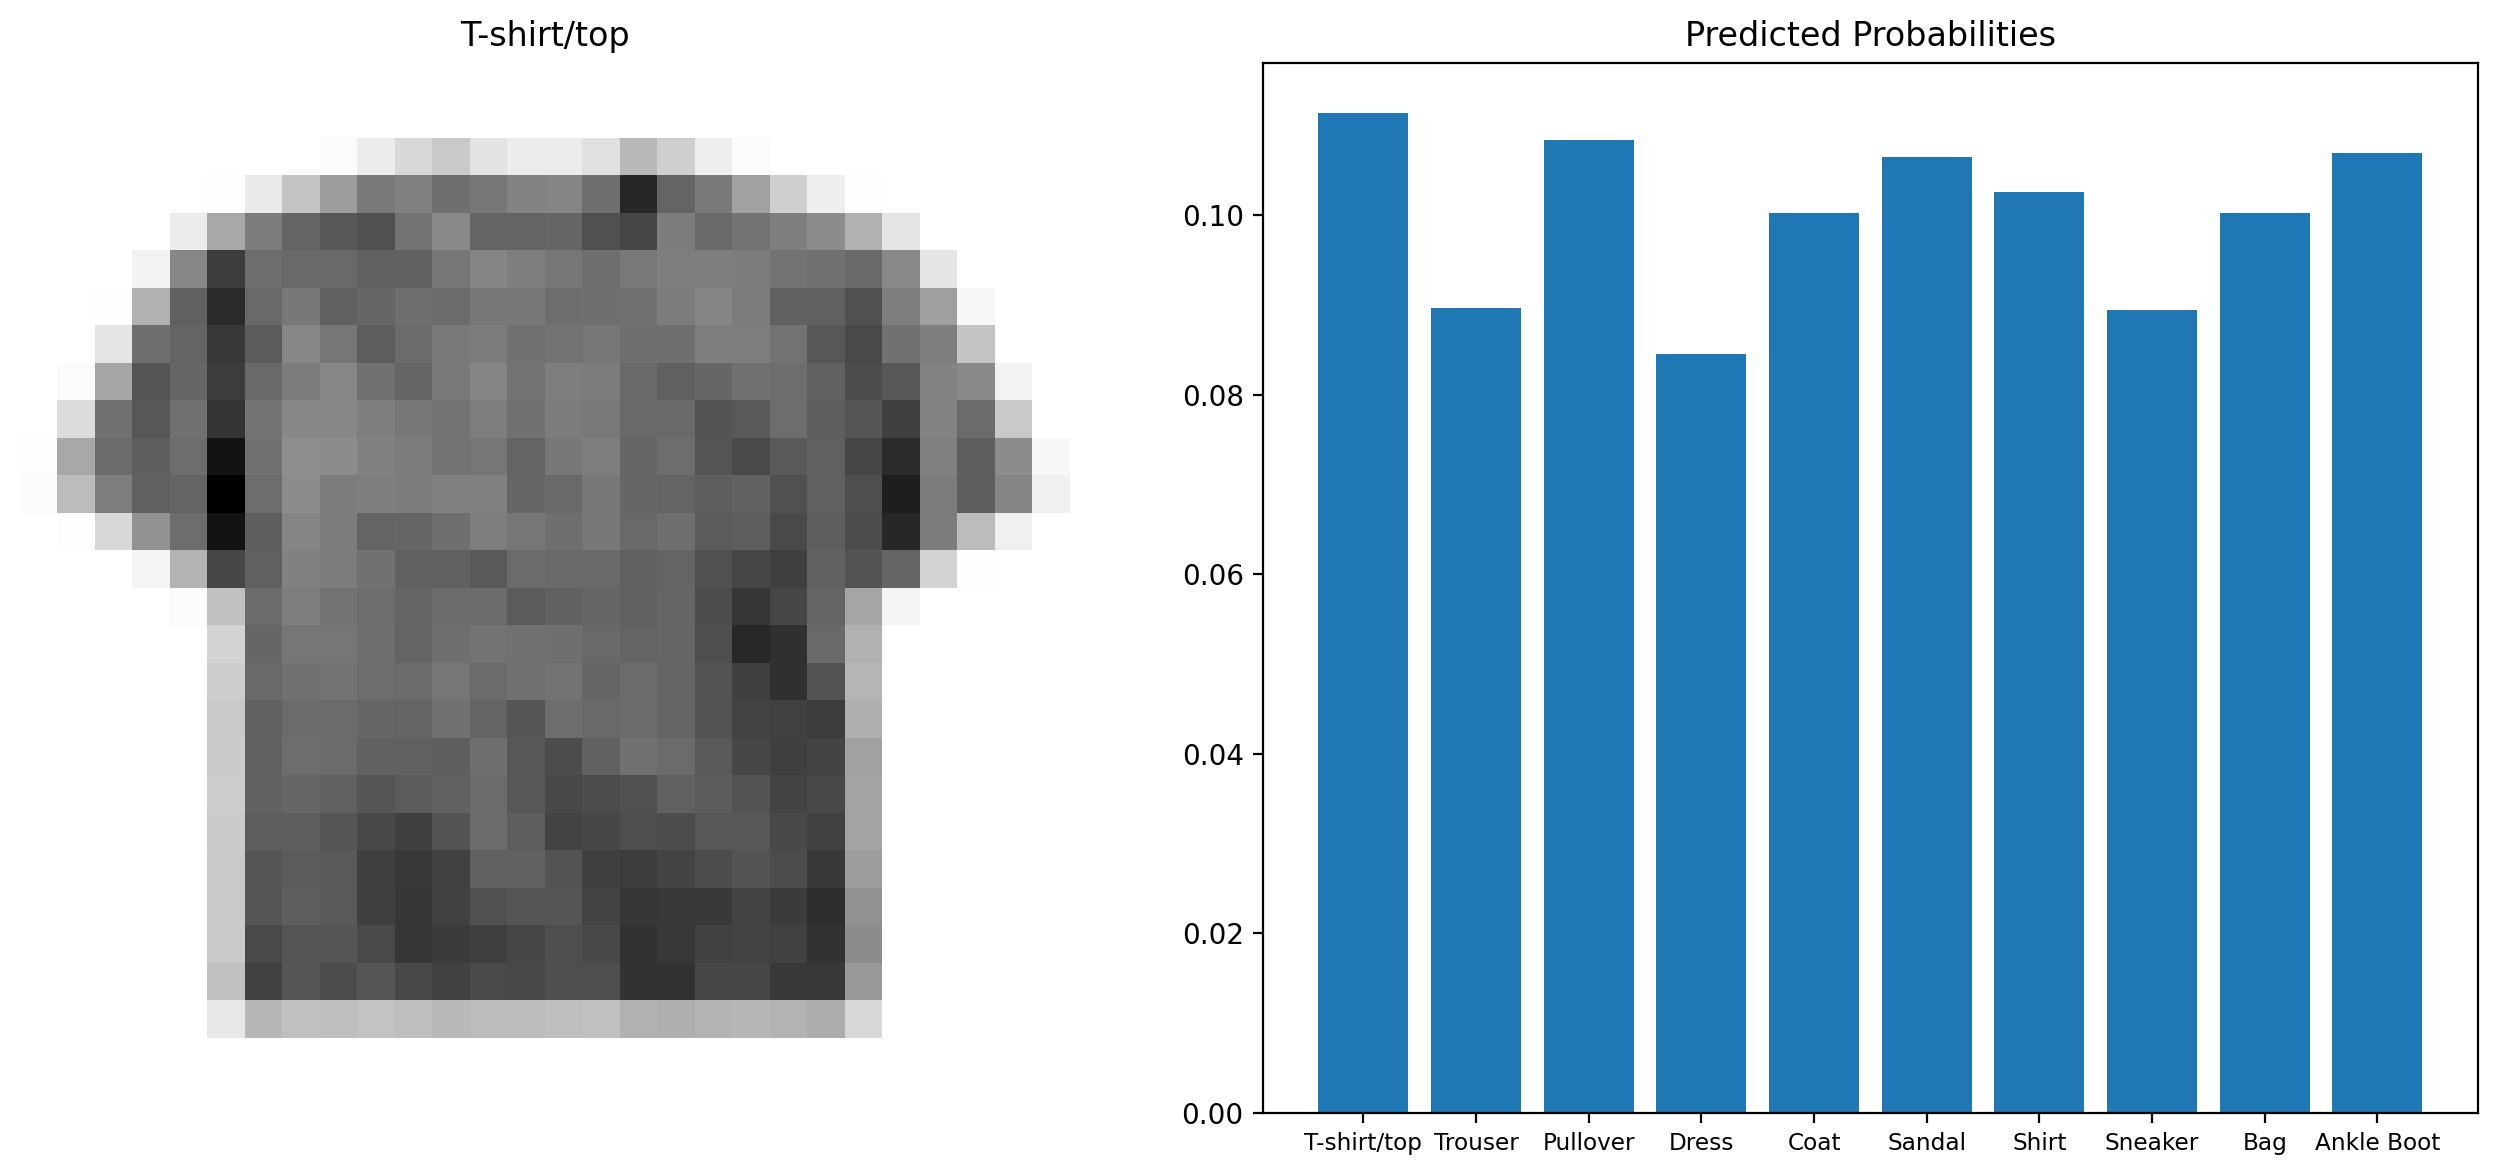

In [31]:
from google.colab import files
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# This will prompt you to upload a file from your local machine
uploaded = files.upload()

# Get the filename of the uploaded image
image_path = next(iter(uploaded))

# Function to preprocess the image from a local file
def preprocess_image_from_file(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),                 # Resize to 28x28 pixels
        transforms.ToTensor(),                      # Convert image to tensor
        transforms.Normalize((0.5,), (0.5,))        # Normalize the tensor
    ])

    # Open the image file
    try:
        image = Image.open(image_path).convert('RGB')
    except IOError as e:
        print(f"Error opening image: {e}")
        return None

    # Apply the transform to the image
    image_tensor = transform(image)

    # Add a batch dimension (needed for model input)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

    return image_tensor

# Preprocess the image
image_tensor = preprocess_image_from_file(image_path)
if image_tensor is None:
    print("Failed to preprocess image.")
else:
    # Load model (assuming you have the model and device setup as in your previous code)
    model, _, _, device = network()  # Make sure your model is loaded
    # model.load_state_dict(torch.load('path_to_your_model.pth'))  # Uncomment if needed

    # Predict the class and probabilities
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        image_tensor = image_tensor.to(device)
        image_tensor = image_tensor.view(image_tensor.shape[0], -1)
        proba = torch.exp(model(image_tensor))
        predicted_class = torch.argmax(proba, dim=1).item()

    # Plot the image and probabilities
    desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)

    # Display the image
    ax1.imshow(image_tensor.squeeze().cpu().numpy().reshape(28, 28), cmap='gray')
    ax1.axis('off')
    ax1.set_title(desc[predicted_class])

    # Display the probabilities
    ax2.bar(range(10), proba.squeeze().cpu().numpy())
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small')
    ax2.set_title('Predicted Probabilities')

    plt.tight_layout()
    plt.show()
